This notebook demonstrates how to use the Gemini API for detecting any objects.

#### Install Generative AI SDK

In [1]:
!pip install -q -U google-generativeai
!pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 586.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

#### Import libraries and dependencies

In [2]:
from google.colab import userdata
import google.generativeai as genai
import re
from PIL import Image
import cv2
import numpy as np

#### Configure Gemini API key

In [3]:
API_KEY = userdata.get('gemini')
genai.configure(api_key=API_KEY)

model = genai.GenerativeModel(model_name='gemini-1.5-pro')

#### Utility functions: Parse response and draw bounding boxes

In [4]:
def parse_bounding_box(response):
    bounding_boxes = re.findall(r'\[(\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\w\s]+)\]', response)

    # Convert each group into a list of integers and labels.
    parsed_boxes = []
    for box in bounding_boxes:
        parts = box.split(',')
        numbers = list(map(int, parts[:-1]))
        label = parts[-1].strip()
        parsed_boxes.append((numbers, label))

    # Return the list of bounding boxes with their labels.
    return parsed_boxes


def draw_bounding_boxes(image, bounding_boxes_with_labels):
    label_colors = {}
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = np.array(image)

    for bounding_box, label in bounding_boxes_with_labels:

        # Normalize the bounding box coordinates
        width, height = image.shape[1], image.shape[0]
        ymin, xmin, ymax, xmax = bounding_box
        x1 = int(xmin / 1000 * width)
        y1 = int(ymin / 1000 * height)
        x2 = int(xmax / 1000 * width)
        y2 = int(ymax / 1000 * height)

        if label not in label_colors:
            color = np.random.randint(0, 256, (3,)).tolist()
            label_colors[label] = color
        else:
            color = label_colors[label]

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        box_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_size[1] - 5
        text_bg_x2 = x1 + text_size[0] + 8
        text_bg_y2 = y1


        cv2.rectangle(image, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        cv2.putText(image, label, (x1 + 2, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, box_thickness)

    image = Image.fromarray(image)
    return image

#### Example 1

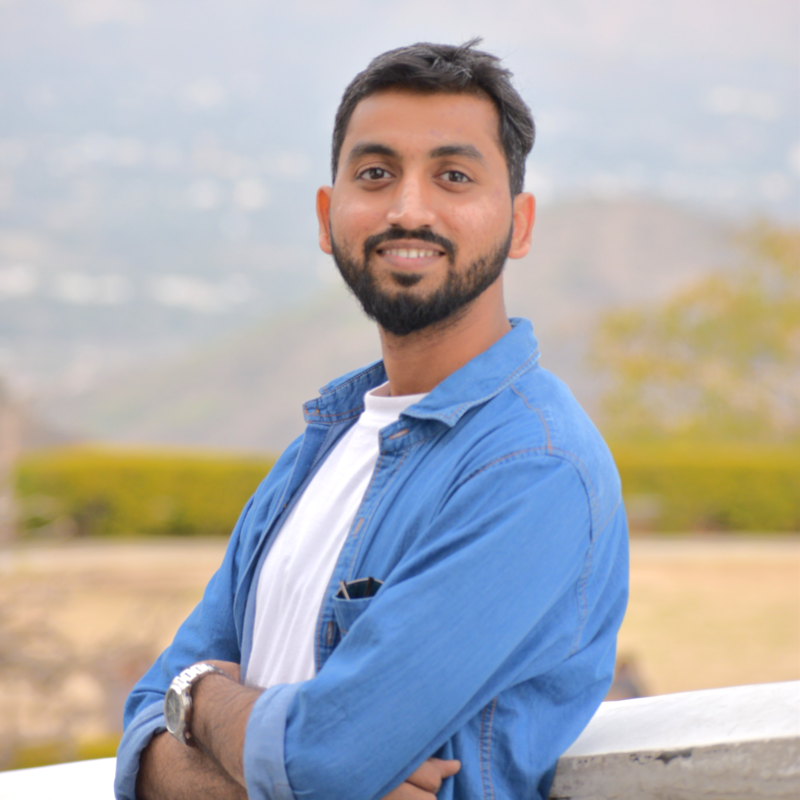

- [55, 146, 1000, 784, man]



In [5]:
input_image = "image1.png" # @param {type : 'string'}
img = Image.open(input_image)

response = model.generate_content([
    img,
    (
        "Return bounding boxes for person in the image in the following format as"
        " a list. \n [ymin, xmin, ymax, xmax, object_name]. If there are more than one person, return separate lists for each person"
    ),
])

result = response.text
display(img)
print(result)

In [6]:
bounding_box = parse_bounding_box(result)
print(bounding_box)

output = draw_bounding_boxes(img, bounding_box)
output_image = "output_" + input_image
output.save(output_image)

[([55, 146, 1000, 784], 'man')]


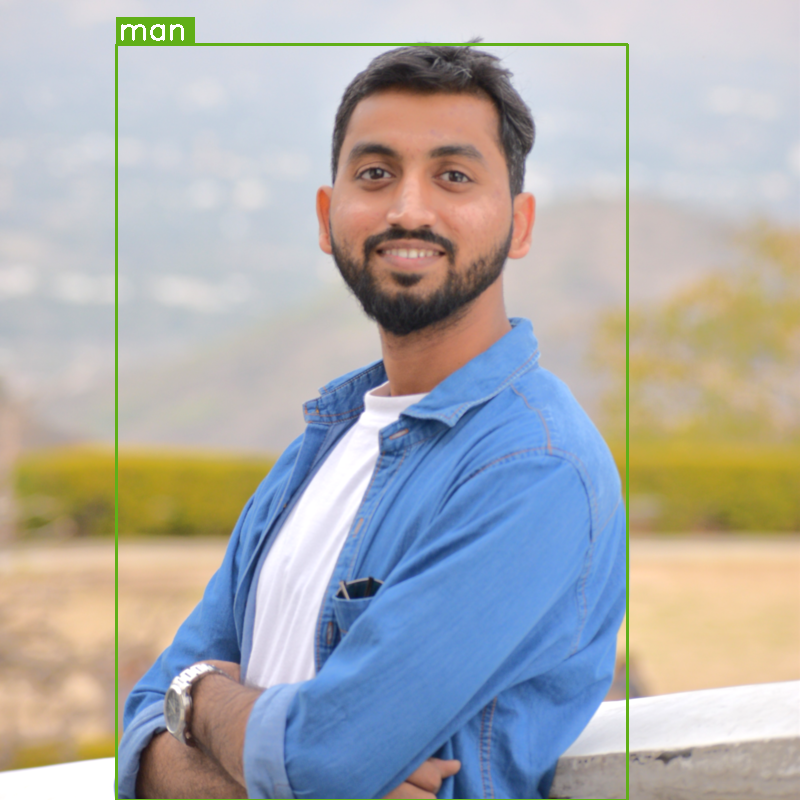

In [7]:
display(output)

#### Example 2:

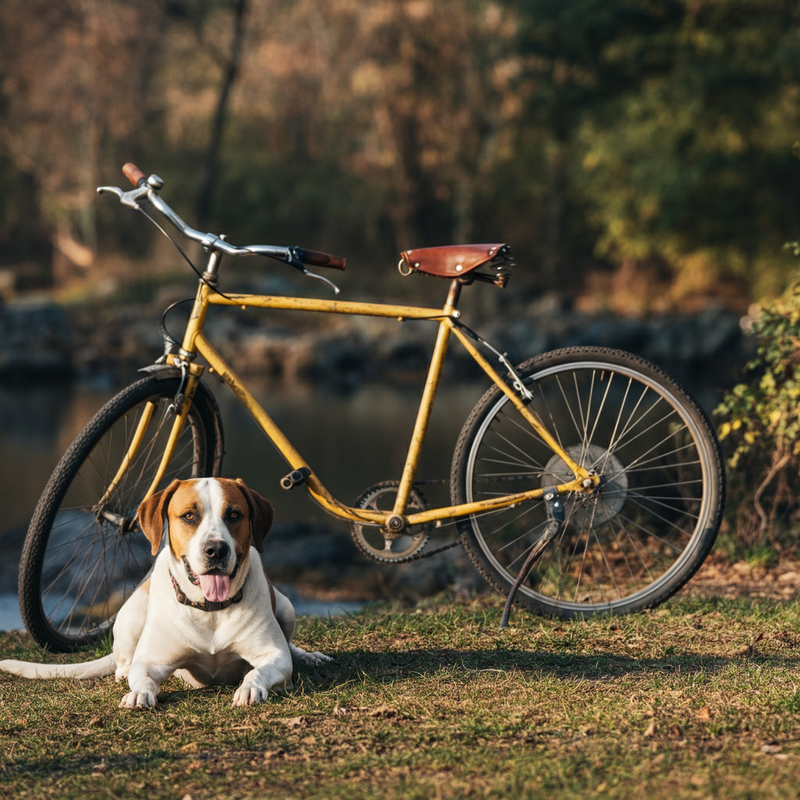

- [200, 28, 794, 908, bicycle]
- [596, 20, 886, 421, dog]



In [8]:
input_image = "image2.png" # @param {type : 'string'}
img = Image.open(input_image)

response = model.generate_content([
    img,
    (
        "Return bounding boxes for all objects in the image in the following format as"
        " a list. \n [ymin, xmin, ymax, xmax, object_name]. If there are more than one object, return separate lists for each object"
    ),
])

result = response.text
display(img)
print(result)

In [9]:
bounding_box = parse_bounding_box(result)
print(bounding_box)

output = draw_bounding_boxes(img, bounding_box)
output_image = "output_" + input_image
output.save(output_image)

[([200, 28, 794, 908], 'bicycle'), ([596, 20, 886, 421], 'dog')]


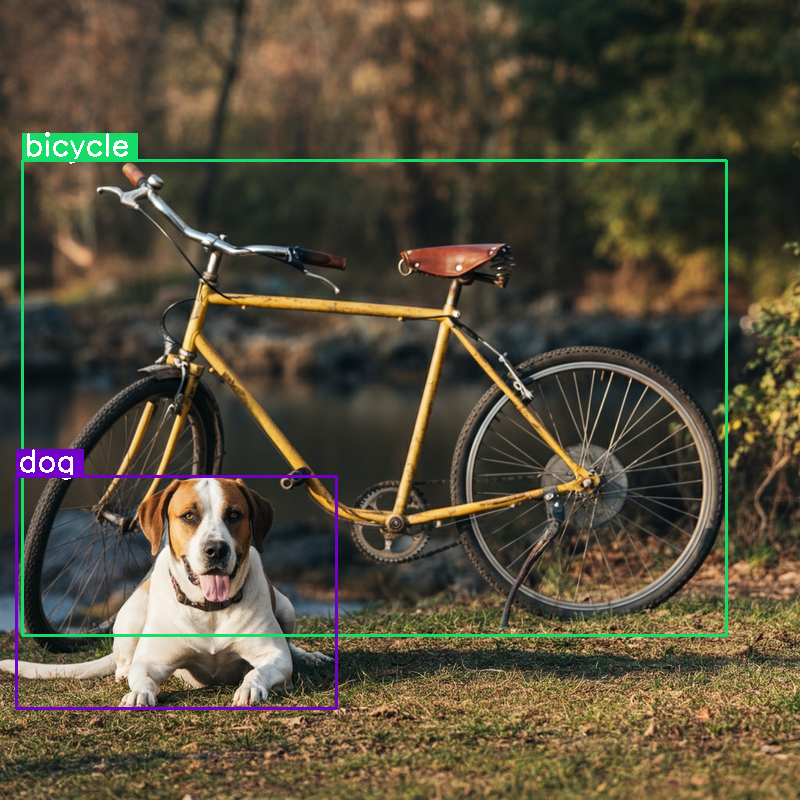

In [10]:
display(output)

#### Example 3:

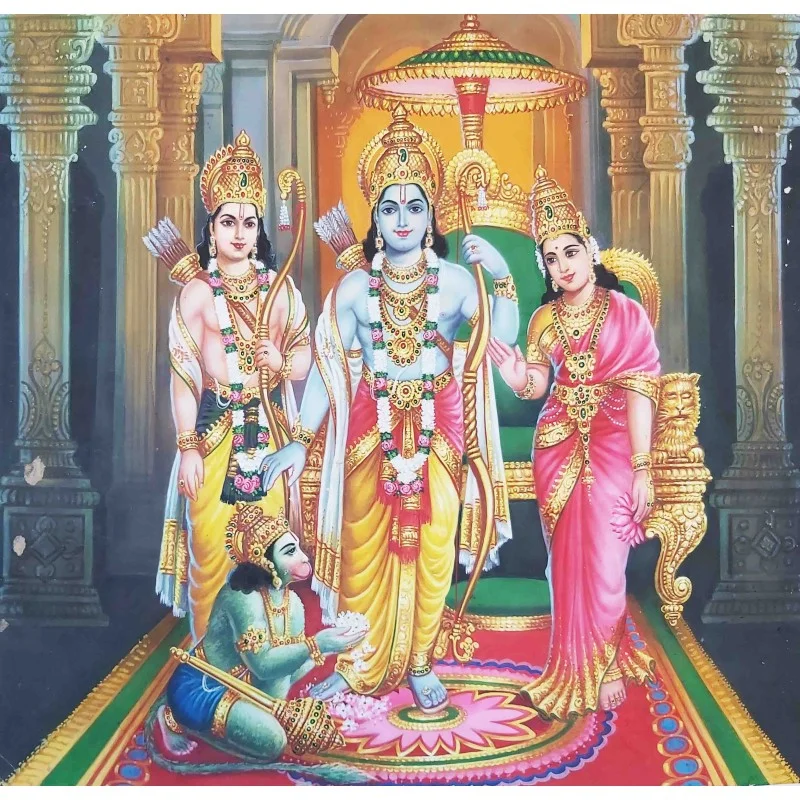

Here are the objects that are present in the image.
- [623, 185, 973, 463, Hanuman]
- [217, 617, 892, 823, Sita]
- [156, 323, 902, 632, Ram]
- [171, 194, 802, 397, Laxman]



In [11]:
input_image = "image3.png" # @param {type : 'string'}
img = Image.open(input_image)

response = model.generate_content([
    img,
    (
        "This is a famous painting of Ram Darbar from Ramayan. Return name and bounding boxes for all the characters in the image in the following format as"
        " a list. \n [ymin, xmin, ymax, xmax, object_name]. "
    ),
])

result = response.text
display(img)
print(result)

In [12]:
result = response.text
result = result.replace("'", '')
bounding_box = parse_bounding_box(result)
print(bounding_box)

output = draw_bounding_boxes(img, bounding_box)
output_image = "output_" + input_image
output.save(output_image)

[([623, 185, 973, 463], 'Hanuman'), ([217, 617, 892, 823], 'Sita'), ([156, 323, 902, 632], 'Ram'), ([171, 194, 802, 397], 'Laxman')]


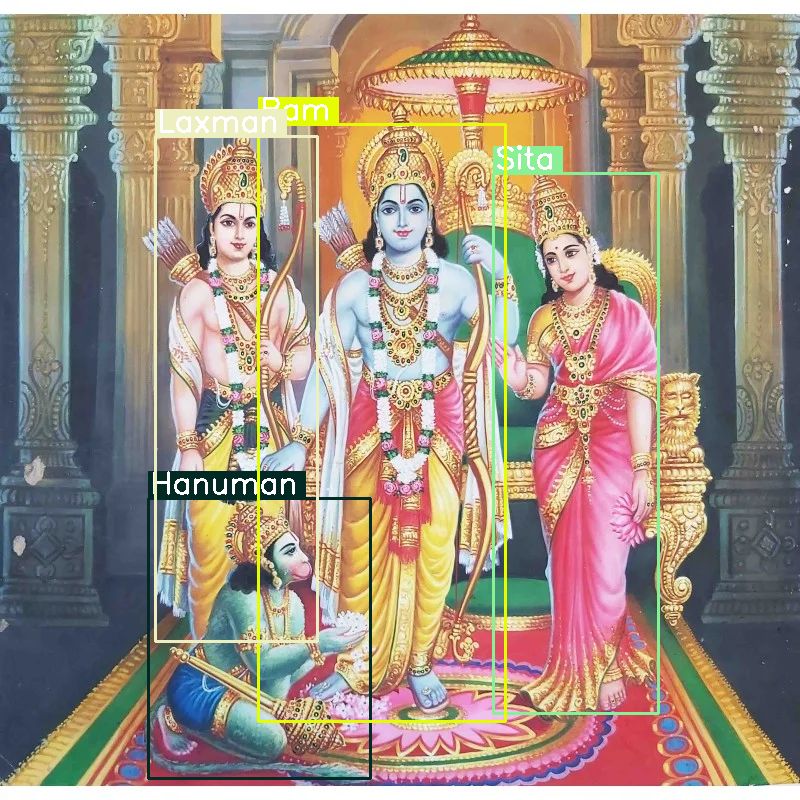

In [13]:
display(output)

#### Example 4:

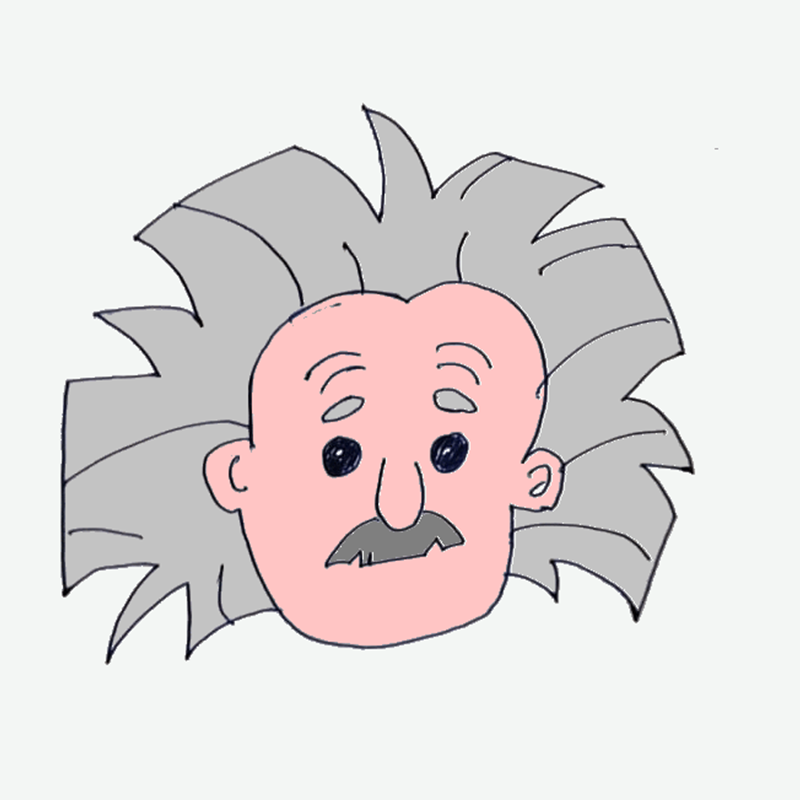

Please find the answer in the requested format below:
- [136, 47, 838, 862, Albert Einstein]



In [14]:
input_image = "image4.png" # @param {type : 'string'}
img = Image.open(input_image)

response = model.generate_content([
    img,
    (
        "Return bounding boxes for a famous personality in the image in the following format as"
        " a list. \n [ymin, xmin, ymax, xmax, object_name]. "
    ),
])

result = response.text
display(img)
print(result)

In [15]:
bounding_box = parse_bounding_box(result)
print(bounding_box)

output = draw_bounding_boxes(img, bounding_box)
output_image = "output_" + input_image
output.save(output_image)

[([136, 47, 838, 862], 'Albert Einstein')]


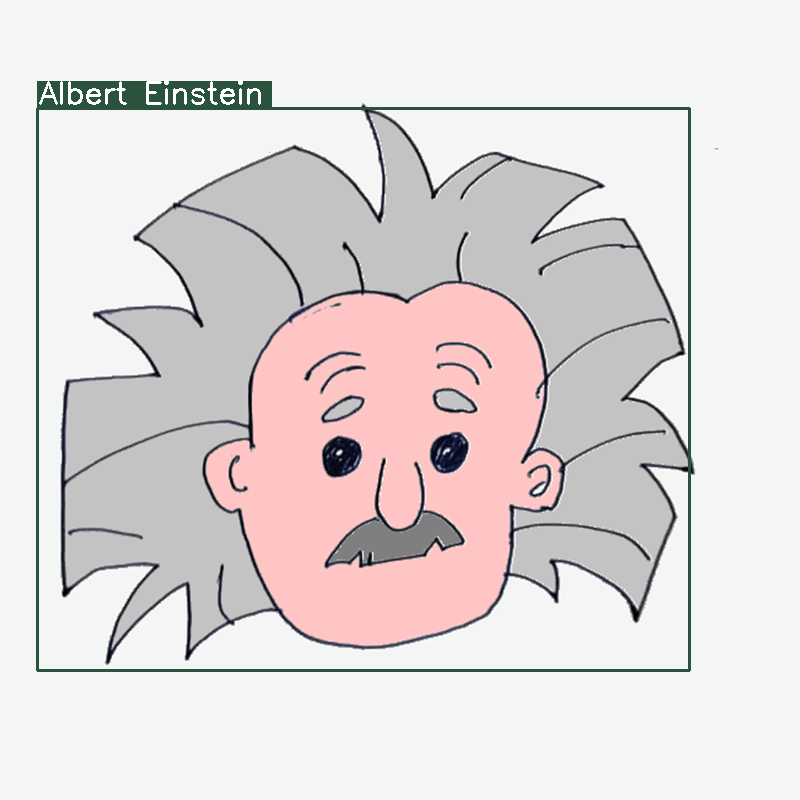

In [16]:
display(output)

#### Gradio App

In [ ]:
import google.generativeai as genai
from PIL import Image
import re
import cv2
import numpy as np
import gradio as gr

def parse_bounding_box(response):
    bounding_boxes = re.findall(r'\[(\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\w\s]+)\]', response)

    # Convert each group into a list of integers and labels.
    parsed_boxes = []
    for box in bounding_boxes:
        parts = box.split(',')
        numbers = list(map(int, parts[:-1]))
        label = parts[-1].strip()
        parsed_boxes.append((numbers, label))

    # Return the list of bounding boxes with their labels.
    return parsed_boxes

# Draw bounding boxes with labels.
def draw_bounding_boxes(image, bounding_boxes_with_labels):
    label_colors = {}
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = np.array(image)

    for bounding_box, label in bounding_boxes_with_labels:
        # Normalize the bounding box coordinates
        width, height = image.shape[1], image.shape[0]
        ymin, xmin, ymax, xmax = bounding_box
        x1 = int(xmin / 1000 * width)
        y1 = int(ymin / 1000 * height)
        x2 = int(xmax / 1000 * width)
        y2 = int(ymax / 1000 * height)

        if label not in label_colors:
            color = np.random.randint(0, 256, (3,)).tolist()
            label_colors[label] = color
        else:
            color = label_colors[label]

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        box_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_size[1] - 5
        text_bg_x2 = x1 + text_size[0] + 8
        text_bg_y2 = y1

        cv2.rectangle(image, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        cv2.putText(image, label, (x1 + 2, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, box_thickness)

    image = Image.fromarray(image)
    return image

def detect_objects(api_key, prompt, input_image):
    genai.configure(api_key=api_key)

    img = Image.open(input_image)

    model = genai.GenerativeModel(model_name='gemini-1.5-pro')

    response = model.generate_content([
        img,
        (
            f"Return bounding boxes for {prompt} in the image in the following format as"
            " a list. \n [ymin, xmin, ymax, xmax, object_name]. "
        ),
    ])

    result = response.text
    result = result[result.find('-'):].strip()

    bounding_box = parse_bounding_box(result)
    output = draw_bounding_boxes(img, bounding_box)

    return output

# Gradio app
demo = gr.Interface(
    fn=detect_objects,
    inputs=[
        gr.Textbox(label="Your Gemini API Key", type="password"),
        gr.Textbox(label="Object(s) to detect", value="famous personality"),
        gr.Image(type="filepath", label="Input Image")
    ],
    outputs=gr.Image(type="pil", label="Detected Image"),
    title="Object Detection using Gemini ✨",
    description="Detect objects in images using the Gemini.",
    allow_flagging="never"
)

if __name__ == "__main__":
    demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:393: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d26ddc02a0e0a88568.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
